In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy.spatial.distance import cdist
from fuzzywuzzy import process


C:\Users\ng_we\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Reading the csv file

hdb_fam = pd.read_csv('../datasets/hdb_fam_clean.csv')

In [3]:
hdb_fam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149805 entries, 0 to 149804
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   transact_date    149805 non-null  object 
 1   town             149805 non-null  object 
 2   floor_area_sqm   149805 non-null  float64
 3   resale_price     149805 non-null  float64
 4   storey           149805 non-null  int64  
 5   flat_type        149805 non-null  object 
 6   age              149805 non-null  int64  
 7   lat              149805 non-null  float64
 8   lon              149805 non-null  float64
 9   mall_dist        149805 non-null  float64
 10  hawker_dist      149805 non-null  float64
 11  mrt_dist         149805 non-null  float64
 12  bus_interchange  149805 non-null  int64  
 13  bus_stop_dist    149805 non-null  float64
 14  pri_sch          149805 non-null  object 
 15  pri_sch_lat      149805 non-null  float64
 16  pri_sch_lon      149805 non-null  floa

### Creating the pri_sch_tier column
---

In [4]:
ballot_df = pd.read_csv('../datasets/p1_ballot_2021.csv')
print(ballot_df.head())

            School  Vacancies  Applications
0      *Admiralty*        210           264
1  *Ahmad Ibrahim*        210            84
2        *Ai Tong*        300           364
3      *Alexandra*        200           223
4   *Anchor Green*        240           271


In [5]:
# Clean the school names by removing special characters and trimming spaces
ballot_df['School'] = ballot_df['School'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()

# Display all the cleaned school names
cleaned_school_names = ballot_df['School'].unique()
cleaned_school_names.sort()  # Sort the names for easier viewing
cleaned_school_names[:5]

array(['Admiralty', 'Ahmad Ibrahim', 'Ai Tong', 'Alexandra',
       'Anchor Green'], dtype=object)

In [6]:
# Calculate the popularity metric as the ratio of Applications to Vacancies
ballot_df['Popularity_Ratio'] = ballot_df['Applications'] / ballot_df['Vacancies']

# Display the dataframe with the new column to verify the calculation
ballot_df.head()

,School,Vacancies,Applications,Popularity_Ratio
0,Admiralty,210,264,1.257143
1,Ahmad Ibrahim,210,84,0.400000
2,Ai Tong,300,364,1.213333
3,Alexandra,200,223,1.115000
4,Anchor Green,240,271,1.129167


In [7]:
# Determine the quantile values for splitting the tiers
quantiles = ballot_df['Popularity_Ratio'].quantile([1/3, 2/3])

# Assign tiers based on quantiles
ballot_df['pri_sch_tier'] = pd.cut(ballot_df['Popularity_Ratio'],
                              bins=[0, quantiles.iloc[0], quantiles.iloc[1], ballot_df['Popularity_Ratio'].max()],
                              labels=['pri_sch_tier_3', 'pri_sch_tier_2', 'pri_sch_tier_1'],
                              include_lowest=True)

# Verify the tier assignments by displaying the first few rows
ballot_df.head()

,School,Vacancies,Applications,Popularity_Ratio,pri_sch_tier
0,Admiralty,210,264,1.257143,pri_sch_tier_1
1,Ahmad Ibrahim,210,84,0.400000,pri_sch_tier_3
2,Ai Tong,300,364,1.213333,pri_sch_tier_1
3,Alexandra,200,223,1.115000,pri_sch_tier_2
4,Anchor Green,240,271,1.129167,pri_sch_tier_2


In [8]:
# Convert all column names to lower case to maintain consistency
ballot_df.columns = ballot_df.columns.str.lower()

ballot_df.head()

,school,vacancies,applications,popularity_ratio,pri_sch_tier
0,Admiralty,210,264,1.257143,pri_sch_tier_1
1,Ahmad Ibrahim,210,84,0.400000,pri_sch_tier_3
2,Ai Tong,300,364,1.213333,pri_sch_tier_1
3,Alexandra,200,223,1.115000,pri_sch_tier_2
4,Anchor Green,240,271,1.129167,pri_sch_tier_2


In [9]:
# Normalize the primary school names in the hdb_fam dataset
hdb_fam['pri_sch_name'] = hdb_fam['pri_sch'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()

In [10]:
# Define a function to perform fuzzy matching and return the best match and its score
def fuzzy_match_school(x, choices, scorer, cutoff):
    match = process.extractOne(x, choices, scorer=scorer, score_cutoff=cutoff)
    return match if match else (None, None)

# Sample some schools for fuzzy matching demonstration
sample_schools = hdb_fam['pri_sch'].sample(n=5, random_state=1).tolist()

# School choices from the original dataset
school_choices = ballot_df['school'].unique()

# Apply fuzzy matching to the sample without specifying a custom scorer
fuzzy_matches = [process.extractOne(school, school_choices, score_cutoff=85) for school in sample_schools]

# Display the sample schools and their fuzzy matches
fuzzy_matches_dict = dict(zip(sample_schools, fuzzy_matches))
fuzzy_matches_dict

{'Rivervale Primary School': ('Rivervale', 90),
 'Elias Park Primary School': ('Elias Park', 90),
 'Cantonment Primary School': ('Cantonment', 90),
 'Keming Primary School': ('Keming', 90),
 "Holy Innocents' Primary School": ('Holy Innocents', 90)}

In [11]:
# Prepare lists of unique school names from both datasets for fuzzy matching
unique_new_school_names = hdb_fam['pri_sch'].unique()
unique_original_school_names = ballot_df['school'].unique()


# Adjust the fuzzy matching process to properly handle cases where no match meets the score cutoff
match_mapping = {}
for school in unique_new_school_names:
    result = process.extractOne(school, unique_original_school_names, score_cutoff=90)
    if result:
        match, score = result
        match_mapping[school] = match

# Apply the match results to the new dataset
hdb_fam['pri_sch_matched'] = hdb_fam['pri_sch'].map(match_mapping).fillna(hdb_fam['pri_sch'])

# Display the number of matches and some examples for verification
len(match_mapping), list(match_mapping.items())[:5]  # Display the number of matches and a few examples


(163,
 [('Geylang Methodist School', 'Geylang Methodist'),
  ('Kuo Chuan Presbyterian Primary School', 'Kuo Chuan Presbyterian'),
  ('Keming Primary School', 'Keming'),
  ('Catholic High School', 'Catholic High'),
  ('Naval Base Primary School', 'Naval Base')])

In [12]:
# Apply fuzzy matching to all school names in the new dataset with a score cutoff to filter for scores less than 90
all_school_matches = {school: process.extractOne(school, school_choices, score_cutoff=0) for school in hdb_fam['pri_sch'].unique()}

# Filter matches to only include those with scores less than 90
matches_less_than_90 = {school: match for school, match in all_school_matches.items() if match and match[1] < 90}

matches_less_than_90

{"Saint Margaret's Primary School": ('AngloChinese Primary', 86),
 'Guangyang Primary School': ('Nanyang', 77),
 "Saint Andrew's Junior School": ('Montfort Junior', 86),
 "Saint Hilda's Primary School": ('St Hildas', 80),
 'Eunos Primary School': ('AngloChinese Primary', 57),
 "Saint Anthony's Primary School": ('AngloChinese Primary', 86),
 'Stamford Primary School': ('Horizon', 50),
 'Pioneer Primary School': ('AngloChinese Primary', 57),
 'Juying Primary School': ('Jurong', 60),
 "CHIJ Saint Nicholas Girls' School": ('CHIJ Katong', 86),
 "Saint Anthony's Canossian Primary School": ('AngloChinese Primary', 86),
 "Saint Stephen's School": ('St Stephens', 82),
 'CHIJ Primary': ('AngloChinese Primary', 86),
 "Saint Gabriel's Primary School": ('AngloChinese Primary', 86)}

In [13]:
# Correction mapping
correction_mapping = {
    "Saint Margarets Primary School": "St Margarets",
    "Saint Andrews Junior School": "St Andrews Junior",
    "CHIJ Saint Nicholas Girls School": "CHIJ St Nicholas Girls",
    "Saint Anthonys Canossian Primary School": "St Anthonys Canossian",
    "Saint Hilda's Primary School": "St Hildas"
}

In [14]:
# Applying corrections to the 'pri_sch' column
hdb_fam['pri_sch'] = hdb_fam['pri_sch'].apply(lambda x: correction_mapping.get(x, x))
hdb_fam.head()

,transact_date,town,floor_area_sqm,resale_price,storey,flat_type,age,lat,lon,mall_dist,hawker_dist,mrt_dist,bus_interchange,bus_stop_dist,pri_sch,pri_sch_lat,pri_sch_lon,pri_sch_name,pri_sch_matched
0,2016-05-01,KALLANG/WHAMPOA,90.0,680000.0,11,4 ROOM,15,1.314299,103.872828,1094.090418,154.753357,330.083069,0,29.427395,Geylang Methodist School,1.317659,103.882504,Geylang Methodist School,Geylang Methodist
1,2012-07-01,BISHAN,130.0,665000.0,8,5 ROOM,34,1.346086,103.855078,866.941448,640.151925,903.659703,1,58.207761,Kuo Chuan Presbyterian Primary School,1.349783,103.854529,Kuo Chuan Presbyterian Primary School,Kuo Chuan Presbyterian
2,2013-07-01,BUKIT BATOK,144.0,838000.0,14,EXECUTIVE,24,1.343867,103.760535,1459.579948,1762.082341,1334.251197,1,214.747860,Keming Primary School,1.345245,103.756265,Keming Primary School,Keming
3,2012-04-01,BISHAN,103.0,550000.0,3,4 ROOM,29,1.358245,103.845504,950.175199,726.215262,907.453484,1,43.396521,Catholic High School,1.354789,103.844934,Catholic High School,Catholic High
4,2017-12-01,YISHUN,83.0,298000.0,2,4 ROOM,34,1.414745,103.835532,729.771895,1540.151439,412.343032,0,129.422752,Naval Base Primary School,1.416280,103.838798,Naval Base Primary School,Naval Base


In [15]:
# Merge the tier information from the original dataset into the new dataset based on the matched school names
hdb_fam = pd.merge(hdb_fam, ballot_df[['school', 'pri_sch_tier']], left_on='pri_sch_matched', right_on='school', how='left')

# Display a few rows of the merged dataset to verify the tier information has been correctly merged
hdb_fam.sample(10)

,transact_date,town,floor_area_sqm,resale_price,storey,flat_type,age,lat,lon,mall_dist,...,mrt_dist,bus_interchange,bus_stop_dist,pri_sch,pri_sch_lat,pri_sch_lon,pri_sch_name,pri_sch_matched,school,pri_sch_tier
32396,2016-11-01,SEMBAWANG,94.0,345000.0,2,4 ROOM,11,1.455300,103.817241,820.256508,...,790.911137,1,98.708810,Endeavour Primary School,1.454176,103.817427,Endeavour Primary School,Endeavour,Endeavour,pri_sch_tier_3
86664,2019-06-01,BUKIT BATOK,121.0,481000.0,11,5 ROOM,36,1.349620,103.756432,827.058061,...,718.372162,1,162.368108,Keming Primary School,1.345245,103.756265,Keming Primary School,Keming,Keming,pri_sch_tier_1
147968,2020-08-01,GEYLANG,70.0,290000.0,5,3 ROOM,44,1.323742,103.904360,1195.731042,...,497.189656,1,105.915740,Eunos Primary School,1.324388,103.904375,Eunos Primary School,Eunos Primary School,NaN,NaN
121962,2014-01-01,ANG MO KIO,92.0,450000.0,8,4 ROOM,41,1.370998,103.857856,1027.660591,...,896.486942,1,81.158262,Jing Shan Primary School,1.371893,103.851811,Jing Shan Primary School,Jing Shan,Jing Shan,pri_sch_tier_2
129619,2016-11-01,TOA PAYOH,120.0,668000.0,26,5 ROOM,23,1.336669,103.858354,1234.031361,...,1255.357163,0,141.829167,Pei Chun Public School,1.337289,103.855474,Pei Chun Public School,Pei Chun Public,Pei Chun Public,pri_sch_tier_2
49831,2013-01-01,BEDOK,82.0,400000.0,8,3 ROOM,36,1.327362,103.926119,413.969710,...,540.285221,1,71.291542,Fengshan Primary School,1.330325,103.931885,Fengshan Primary School,Fengshan,Fengshan,pri_sch_tier_2
21803,2019-09-01,WOODLANDS,92.0,300000.0,5,4 ROOM,23,1.433426,103.798862,570.783922,...,804.553106,0,24.239608,Woodlands Ring Primary School,1.434770,103.797841,Woodlands Ring Primary School,Woodlands,Woodlands,pri_sch_tier_1
41502,2019-06-01,YISHUN,92.0,583000.0,8,4 ROOM,8,1.426927,103.842897,690.338707,...,942.193656,1,70.046963,Huamin Primary School,1.426998,103.844210,Huamin Primary School,Huamin,Huamin,pri_sch_tier_1
98138,2017-10-01,HOUGANG,119.0,629000.0,14,5 ROOM,24,1.352538,103.878703,105.140832,...,672.503750,1,93.835453,Paya Lebar Methodist Girls' School,1.350805,103.885587,Paya Lebar Methodist Girls School,Paya Lebar Methodist Girls,Paya Lebar Methodist Girls,pri_sch_tier_1
39202,2015-06-01,HOUGANG,104.0,417000.0,11,4 ROOM,35,1.371535,103.884223,700.635170,...,973.139152,1,110.685169,Xinmin Primary School,1.371415,103.883039,Xinmin Primary School,Xinmin,Xinmin,pri_sch_tier_1


In [16]:
# Drop rows with NaN values in the 'pri_sch_tier' column to clean the dataset
hdb_fam_clean = hdb_fam.dropna(subset=['pri_sch_tier'])

# Drop the specified columns from the merged data
hdb_fam_eda = hdb_fam_clean.drop(columns=['pri_sch_name', 'pri_sch_matched', 'school', 'pri_sch_lat', 'pri_sch_lon'])

# Display a few rows of the dataset after dropping the specified columns to verify
hdb_fam_eda.sample(10)


,transact_date,town,floor_area_sqm,resale_price,storey,flat_type,age,lat,lon,mall_dist,hawker_dist,mrt_dist,bus_interchange,bus_stop_dist,pri_sch,pri_sch_tier
28866,2014-09-01,JURONG WEST,110.0,525000.0,5,5 ROOM,20,1.335679,103.705141,451.145669,1365.080585,324.615318,1,130.316447,Frontier Primary School,pri_sch_tier_1
83263,2016-04-01,CHOA CHU KANG,149.0,575000.0,11,EXECUTIVE,26,1.392796,103.746732,398.742213,3280.311810,532.289122,0,89.145312,Kranji Primary School,pri_sch_tier_3
52739,2015-10-01,SENGKANG,67.0,343888.0,5,3 ROOM,10,1.383813,103.898808,379.888168,2019.532012,608.009232,1,92.820869,North Vista Primary School,pri_sch_tier_3
117693,2019-03-01,GEYLANG,92.0,473000.0,2,4 ROOM,39,1.318212,103.884752,345.406091,379.678440,317.708545,0,56.423169,Geylang Methodist School,pri_sch_tier_2
97721,2020-08-01,HOUGANG,67.0,330000.0,11,3 ROOM,9,1.382273,103.880129,282.139329,869.589593,1482.834216,1,50.078600,Hougang Primary School,pri_sch_tier_1
143239,2017-03-01,ANG MO KIO,117.0,844000.0,8,5 ROOM,10,1.371832,103.853671,637.904714,129.926425,491.299094,1,84.925515,Jing Shan Primary School,pri_sch_tier_2
21983,2018-07-01,JURONG WEST,110.0,480000.0,17,5 ROOM,20,1.338968,103.697950,307.989708,1799.403202,201.688382,0,35.986943,Jurong West Primary School,pri_sch_tier_2
33560,2017-11-01,CHOA CHU KANG,99.0,295000.0,5,4 ROOM,43,1.379762,103.754969,280.534855,1950.369953,777.202032,1,75.428091,Teck Whye Primary School,pri_sch_tier_3
85892,2018-11-01,JURONG EAST,92.0,430000.0,23,4 ROOM,8,1.323784,103.738518,1061.856818,536.294440,1166.952152,1,180.460228,Fuhua Primary School,pri_sch_tier_2
120063,2018-07-01,YISHUN,84.0,312000.0,8,4 ROOM,36,1.435780,103.839171,406.769931,1316.598964,860.323737,1,160.570553,Xishan Primary School,pri_sch_tier_1


### Distance to CBD column
---

In [17]:
# Define the coordinates for the Central Business District (CBD)
cbd_coordinates = (1.2831, 103.8511)

# Define a function to calculate distance using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

# Recalculate distances using the Haversine formula
hdb_fam_eda.loc[:,'cbd_dist_km'] = hdb_fam_eda.apply(
    lambda row: haversine(row['lat'], row['lon'], cbd_coordinates[0], cbd_coordinates[1]),
    axis=1
)

# Display the first few rows to confirm the new distance calculations
hdb_fam_eda[['lat', 'lon', 'cbd_dist_km']].head()


,lat,lon,cbd_dist_km
0,1.314299,103.872828,4.227211
1,1.346086,103.855078,7.017668
2,1.343867,103.760535,12.125001
3,1.358245,103.845504,8.378885
4,1.414745,103.835532,14.740182


In [18]:
# Dropping the hdb lat and long features as it will not be used in EDA

hdb_fam_eda = hdb_fam_eda.drop(columns=['lat', 'lon'])
hdb_fam_eda.head()

,transact_date,town,floor_area_sqm,resale_price,storey,flat_type,age,mall_dist,hawker_dist,mrt_dist,bus_interchange,bus_stop_dist,pri_sch,pri_sch_tier,cbd_dist_km
0,2016-05-01,KALLANG/WHAMPOA,90.0,680000.0,11,4 ROOM,15,1094.090418,154.753357,330.083069,0,29.427395,Geylang Methodist School,pri_sch_tier_2,4.227211
1,2012-07-01,BISHAN,130.0,665000.0,8,5 ROOM,34,866.941448,640.151925,903.659703,1,58.207761,Kuo Chuan Presbyterian Primary School,pri_sch_tier_2,7.017668
2,2013-07-01,BUKIT BATOK,144.0,838000.0,14,EXECUTIVE,24,1459.579948,1762.082341,1334.251197,1,214.747860,Keming Primary School,pri_sch_tier_1,12.125001
3,2012-04-01,BISHAN,103.0,550000.0,3,4 ROOM,29,950.175199,726.215262,907.453484,1,43.396521,Catholic High School,pri_sch_tier_1,8.378885
4,2017-12-01,YISHUN,83.0,298000.0,2,4 ROOM,34,729.771895,1540.151439,412.343032,0,129.422752,Naval Base Primary School,pri_sch_tier_2,14.740182


### Overall HDB Resale Value Insights
---

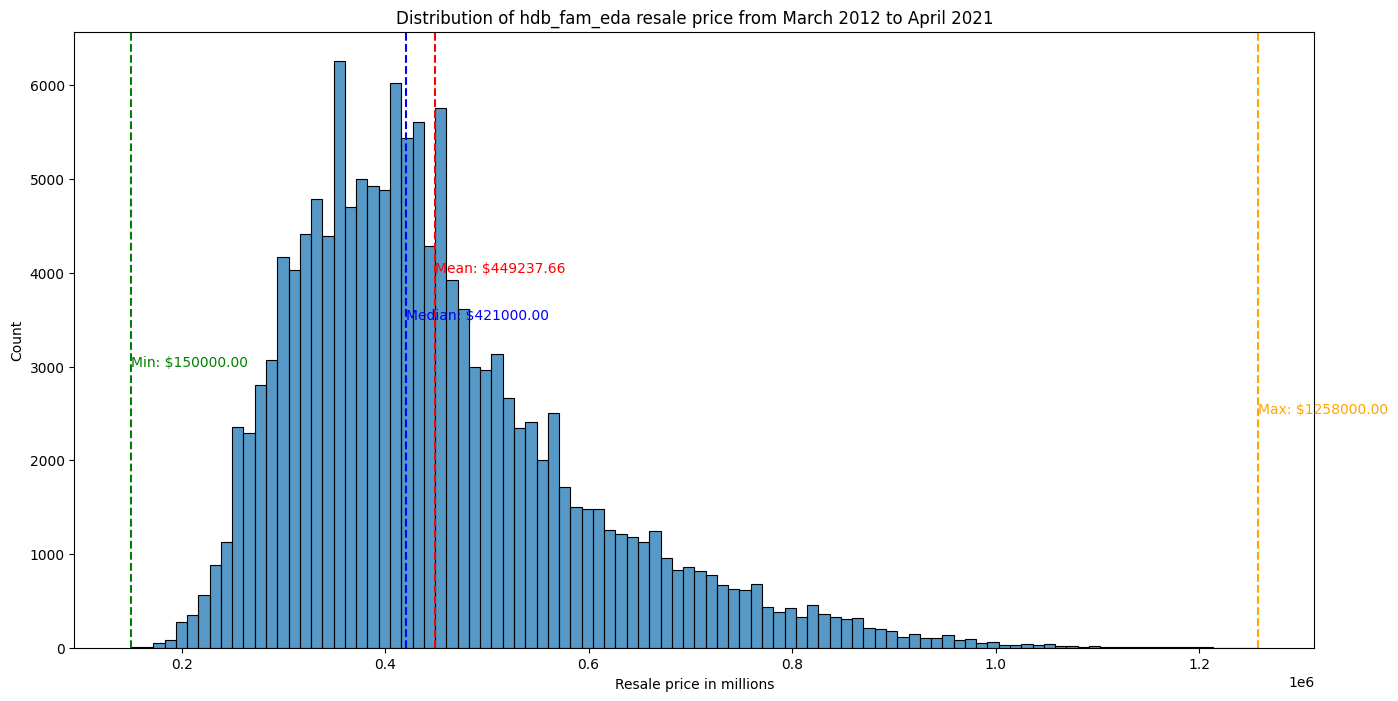

In [19]:
# Distribution of resale price
plt.figure(figsize=(16, 8))
sns.histplot(hdb_fam_eda['resale_price'], bins=100)
plt.xlabel('Resale price in millions')
plt.ylabel('Count')
plt.title('Distribution of hdb_fam_eda resale price from March 2012 to April 2021')

# Calculate mean, median, min, and max
mean_price = np.mean(hdb_fam_eda['resale_price'])
median_price = np.median(hdb_fam_eda['resale_price'])
min_price = np.min(hdb_fam_eda['resale_price'])
max_price = np.max(hdb_fam_eda['resale_price'])

# Add mean, median, min, and max to the plot with vertical lines
plt.axvline(mean_price, color='red', linestyle='--')
plt.axvline(median_price, color='blue', linestyle='--')
plt.axvline(min_price, color='green', linestyle='--')
plt.axvline(max_price, color='orange', linestyle='--')

# Add labels for mean, median, min, and max
plt.text(mean_price, 4000, f'Mean: ${mean_price:.2f}', fontsize=10, color='red')
plt.text(median_price, 3500, f'Median: ${median_price:.2f}', fontsize=10, color='blue')
plt.text(min_price, 3000, f'Min: ${min_price:.2f}', fontsize=10, color='green')
plt.text(max_price, 2500, f'Max: ${max_price:.2f}', fontsize=10, color='orange')

plt.show()

**Interpretation:**
* HDB Resale prices between 2012 to 2021 is mostly normally distributed, with a right (positive) skew
* Mean resale value is about 450K

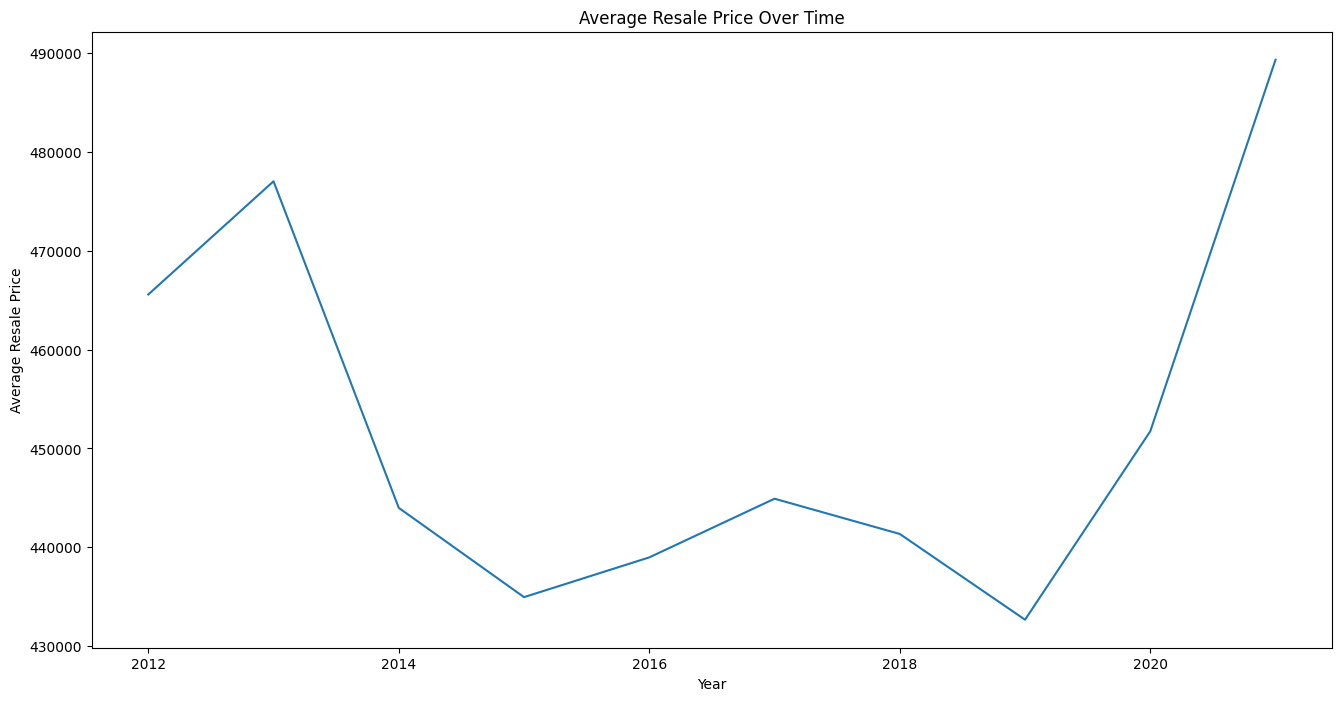

In [20]:
# Checking how resale prices have changed over time in the data set

# Converting 'transact_date' to datetime format
hdb_fam_eda['transact_date'] = pd.to_datetime(hdb_fam_eda['transact_date'])

# Creating a 'year' column
hdb_fam_eda['year'] = hdb_fam_eda['transact_date'].dt.year

# Adjusting figure size
plt.figure(figsize=(16, 8))

# Plotting
plt.plot(hdb_fam_eda.groupby('year')['resale_price'].mean())

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Average Resale Price')
plt.title('Average Resale Price Over Time')

# Show plot
plt.show()

**Interpretation:**
* HDB Resale prices experienced an extended trough between the years of 2014 to 2019 before recovering again in 2020 during pandemic years.
* Current HDB Resale prices are in its 10 year highs

C:\Users\ng_we\AppData\Local\Temp\ipykernel_21160\3181416026.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='town', y='age', data=hdb_fam_eda, palette=palette)


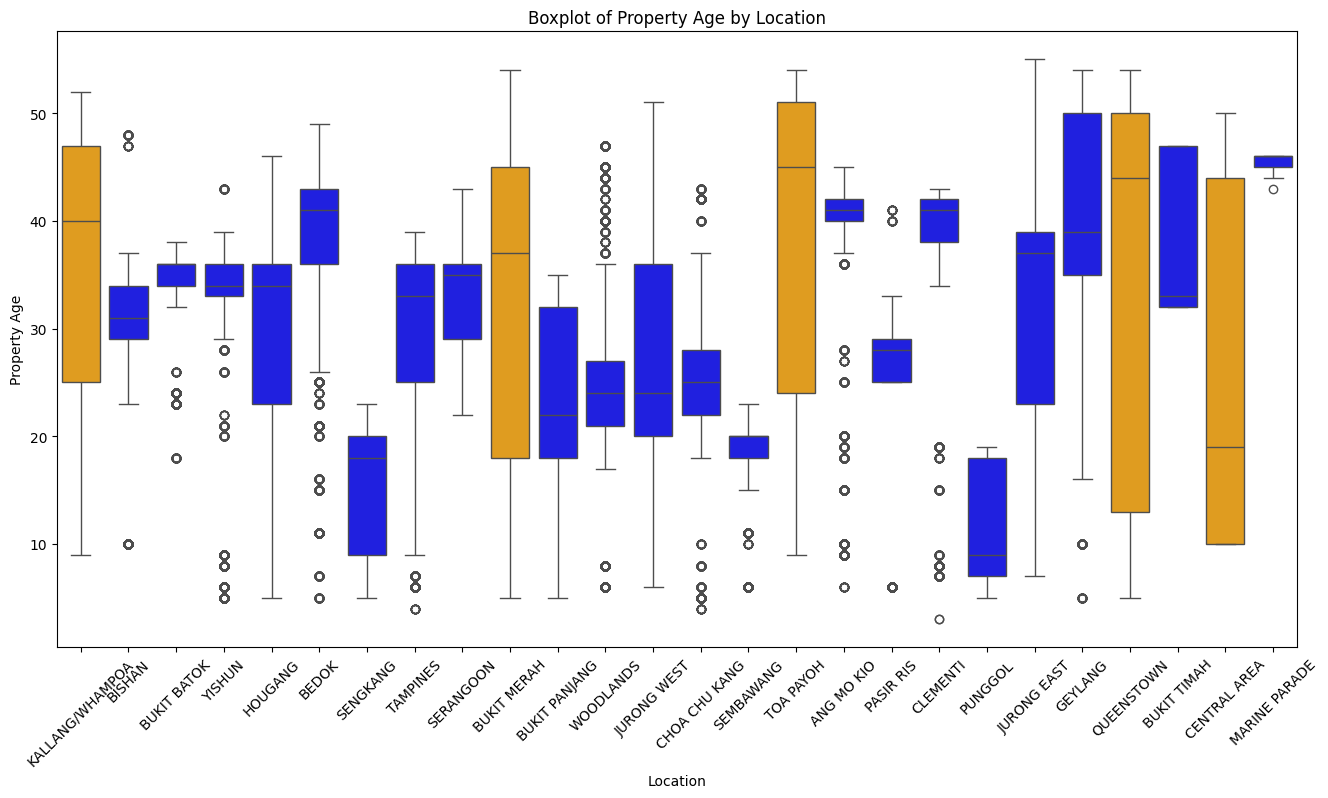

In [21]:
# Define towns of large price variance
large_range = ['KALLANG/WHAMPOA', 'BUKIT MERAH', 'TOA PAYOH', 'QUEENSTOWN', 'CENTRAL AREA']

# Create a custom color palette
colors = ['orange' if town in large_range else 'blue' for town in hdb_fam_eda['town'].unique()]
palette = dict(zip(hdb_fam_eda['town'].unique(), colors))

# Plot the boxplot with the custom color palette
plt.figure(figsize=(16, 8))
sns.boxplot(x='town', y='age', data=hdb_fam_eda, palette=palette)
plt.xlabel('Location')
plt.ylabel('Property Age')
plt.title('Boxplot of Property Age by Location')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

**Interpretation:**
* Towns highlighted in orange have a large interquartile age range. These happen to be towns that are mature estates, showing that there are many new flat developments in the company of older flats.
* This could suggest that these are towns whereby the urban redevelopment authorities are trying to keep modern and alive in the midst of developing new areas.

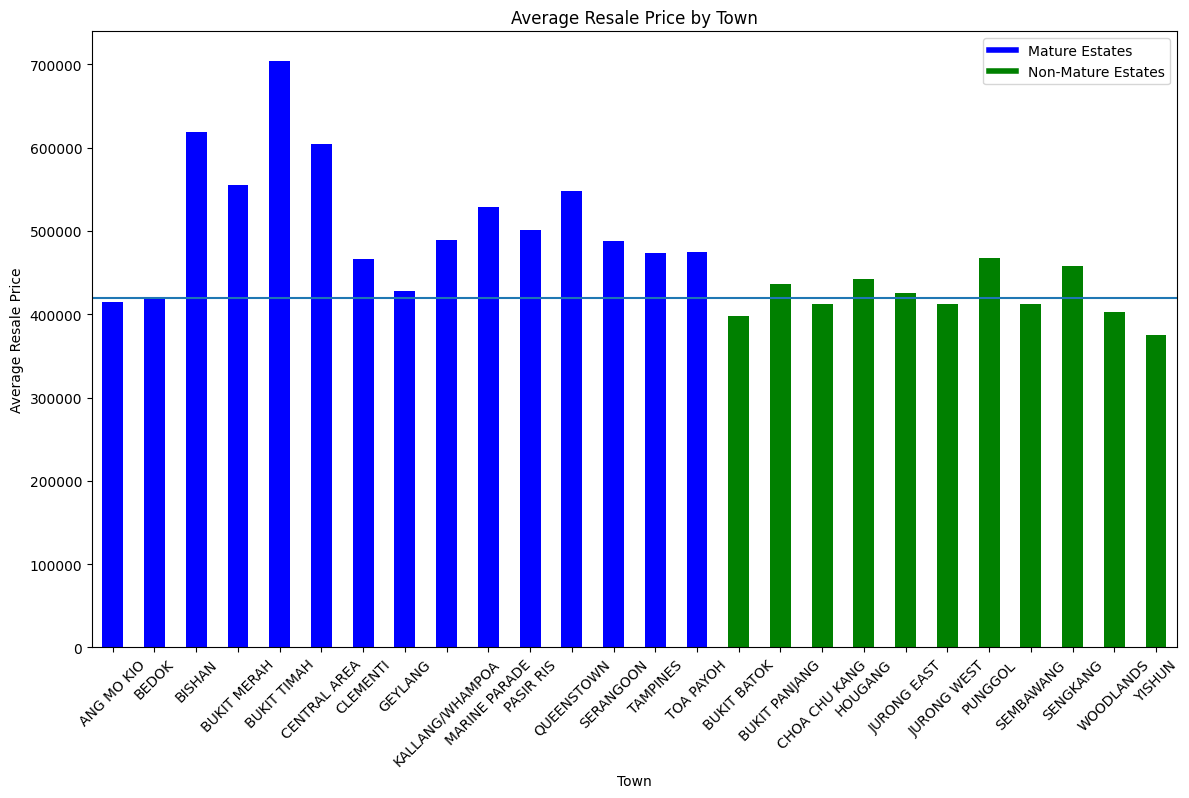

In [22]:
# Custom order of towns
custom_order = ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'CLEMENTI', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'QUEENSTOWN', 'SERANGOON', 'TAMPINES', 'TOA PAYOH',
                'BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST', 'PUNGGOL', 'SEMBAWANG', 'SENGKANG', 'WOODLANDS', 'YISHUN']

# Calculate the average resale price for each town
average_resale_price_by_town = hdb_fam.groupby('town')['resale_price'].mean().loc[custom_order]

# Define colors based on custom order
bar_colors = ['blue' if town in custom_order[:15] else 'green' for town in average_resale_price_by_town.index]

# Plot the bar chart
plt.figure(figsize=(14, 8))
average_resale_price_by_town.plot(kind='bar', color=bar_colors)
plt.axhline(420000)
plt.xlabel('Town')
plt.ylabel('Average Resale Price')
plt.title('Average Resale Price by Town')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)  

# Add legend
blue_patch = plt.Line2D([0], [0], color='blue', lw=4, label='Mature Estates')
green_patch = plt.Line2D([0], [0], color='green', lw=4, label='Non-Mature Estates')
plt.legend(handles=[blue_patch, green_patch])

plt.show()

**Interpretation:**
* This bar graph shows that there are towns that belong to the mature estate category that are affordable which often includes
    * Established infrastructure: schools, parks, malls, hospitals, transportation networks
    * Accessibility: closer to city centre
    * Appreciation potential: Established reputation, desirable location, limited availability of land

A closer look into the 3 specific towns in which resale value is in comparison with non-mature estates, we have identified that there is also future value potential that comes with these towns:
1. Transport developments in Bedok area [(ura.gov.sg)](https://www.ura.gov.sg/-/media/Corporate/Planning/DMP19/Regional-Resources/DMP19-East-Region-Brochures-latest.pdf?la=en)
2. Amenity developments in Geylang area [(propertyguru)](https://www.propertyguru.com.sg/areainsider/paya-lebar/article/paya-lebar-masterplan-2068)
3. Transport developments in Ang Mo Kio area [(propertyguru)](https://www.propertyguru.com.sg/areainsider/ang-mo-kio/article/the-masterplan-of-ang-mo-kio-7021#:~:text=Ang%20Mo%20Kio%20in%20the,the%20Thomson%20East%20Coast%20Line)

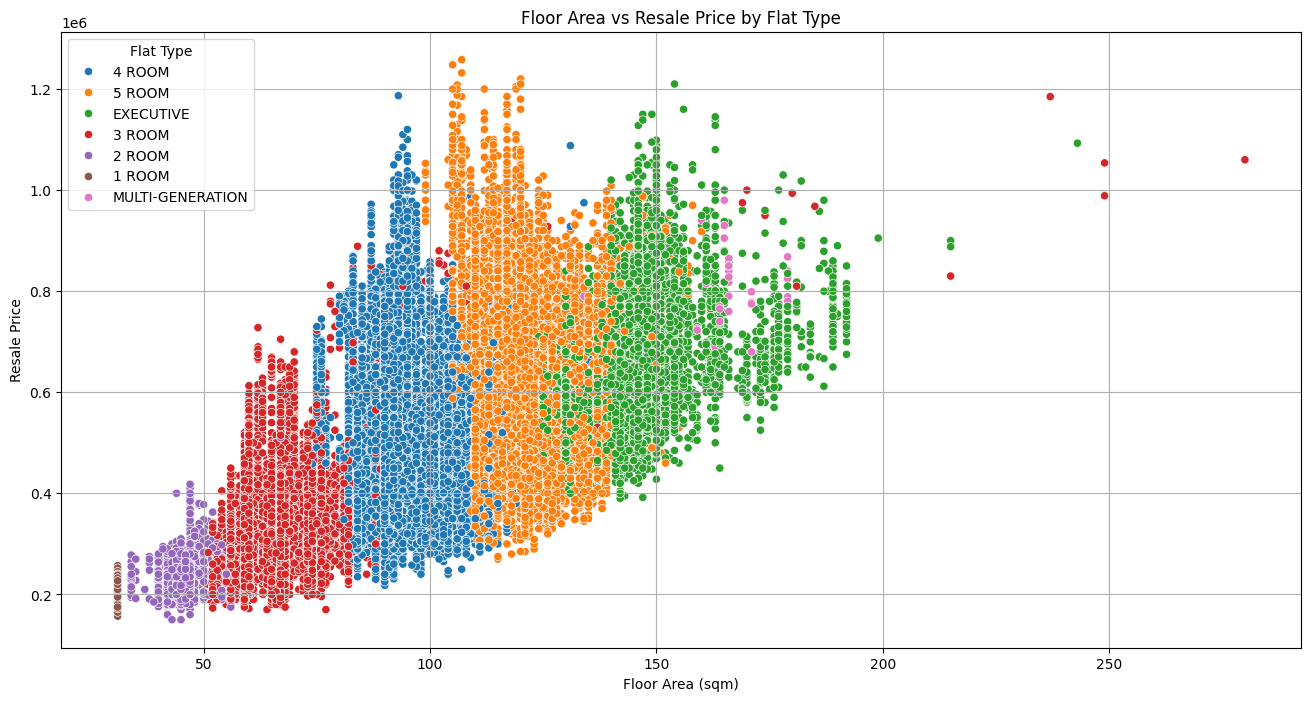

In [23]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x='floor_area_sqm', y='resale_price', hue='flat_type', data=hdb_fam)
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price')
plt.title('Floor Area vs Resale Price by Flat Type')
plt.grid(True)
plt.legend(title='Flat Type')
plt.show()

**Interpretation:**
* 4 and 5 room flat types offer the most price variance, which gives buyers options in pricing vs town. 
* Availability of 3 room flat types that are above 150sqm, larger than most 5 room flats. Flat type doesn't always determine floor area.

Text(0.5, 1.0, 'Relationship between HDB age and resale price with best fit line')

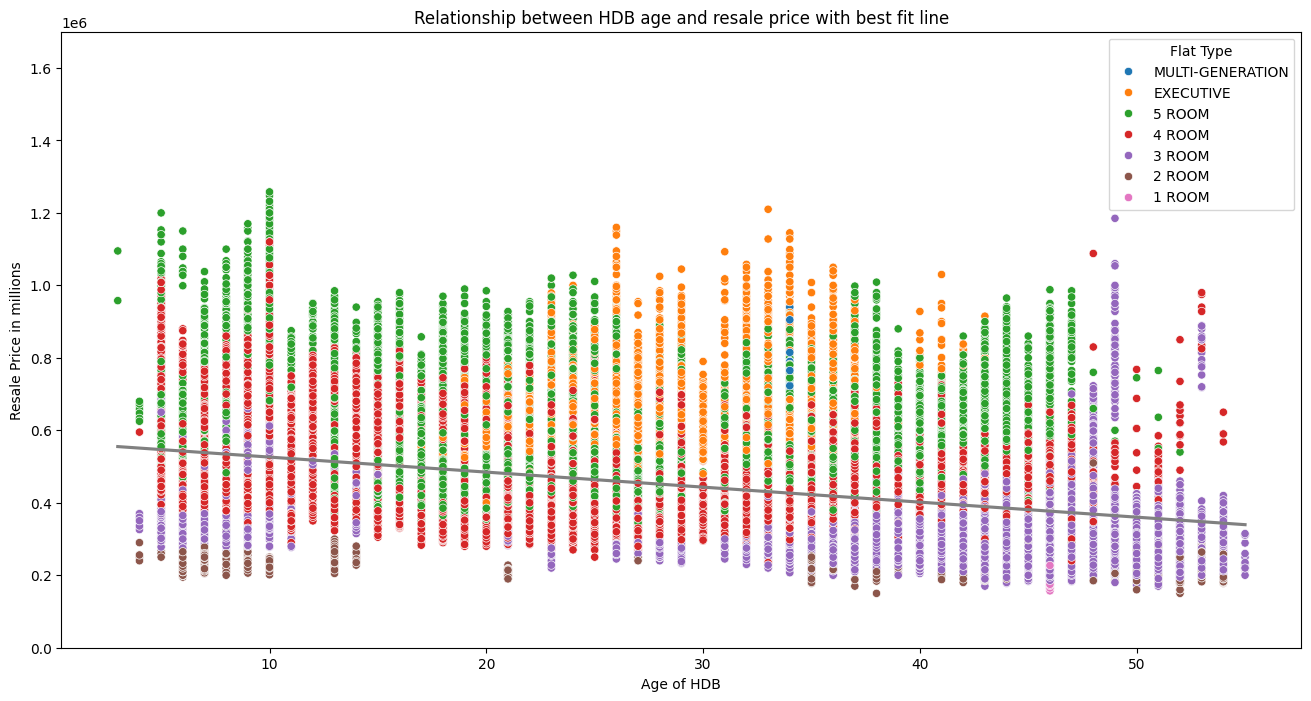

In [24]:
# Define the order of flat types for the legend
flat_type_order = ['MULTI-GENERATION', 'EXECUTIVE', '5 ROOM', '4 ROOM', '3 ROOM', '2 ROOM', '1 ROOM']

# Scatter plot of hdb age and resale price with best fit line
plt.figure(figsize=(16, 8))
sns.scatterplot(data=hdb_fam, x='age', y='resale_price', hue='flat_type', hue_order=flat_type_order)
plt.ylim(0,1700000)
sns.regplot(data=hdb_fam, x='age', y='resale_price', scatter=False, color='gray', ci=None)
plt.xlabel('Age of HDB')
plt.ylabel('Resale Price in millions')
plt.legend(title='Flat Type')
plt.title('Relationship between HDB age and resale price with best fit line')

**Interpretation:**
* Resale price decreases as age of HDB increases. 
* A large area of scatters that of 4 room flat types between 5 to 15 years of HDB age
* Most expensive unit sold was a 5 room flat type

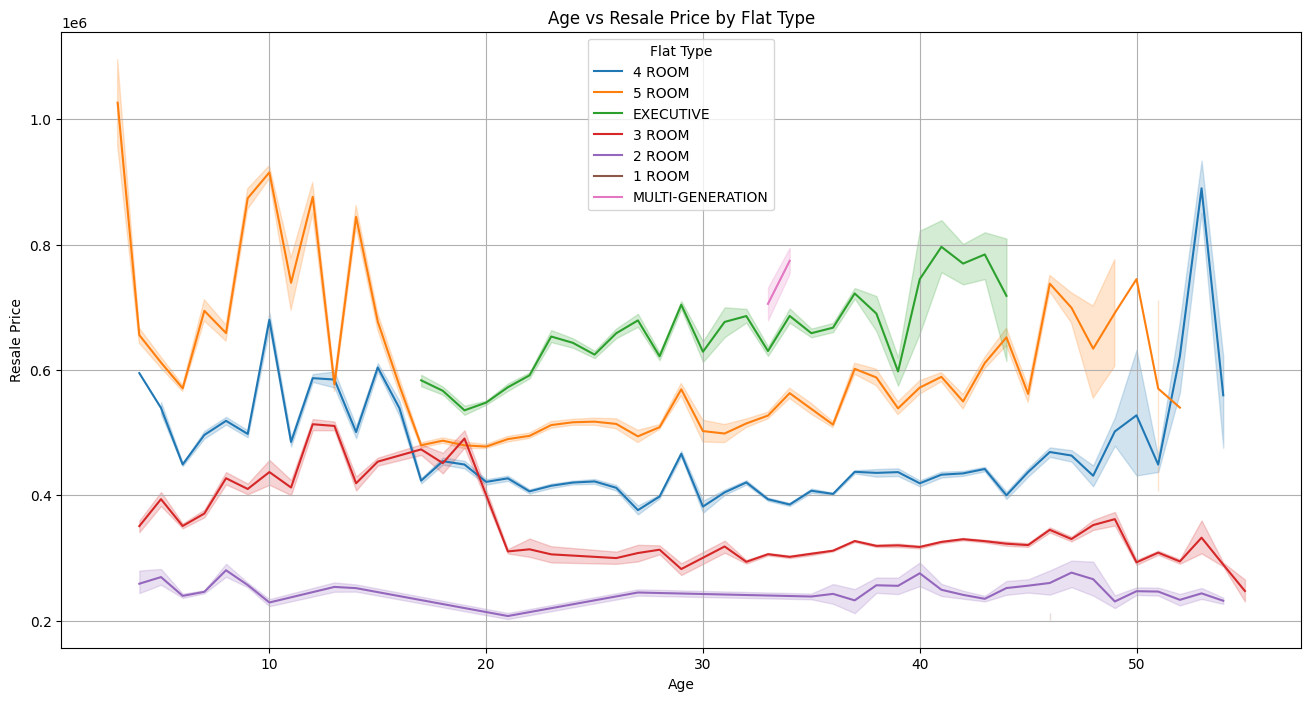

In [25]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='age', y='resale_price', hue='flat_type', data=hdb_fam)
plt.xlabel('Age')
plt.ylabel('Resale Price')
plt.title('Age vs Resale Price by Flat Type')
plt.grid(True)
plt.legend(title='Flat Type')
plt.show()

**Interpretation:**
Despite the previous chart, this chart shows that age can also increase together with price, especially after 20 years. This could likely be due to these towns becoming mature estates and having more amenities, transport and limited land options.

### Specific charts for family personas
---

In [26]:
# Dropping 1, 2 and 3 room types as the audience is focused on families
categories_to_drop = ['1 ROOM', '2 ROOM', '3 ROOM']
hdb_4n5_eda = hdb_fam_eda[~hdb_fam_eda['flat_type'].isin(categories_to_drop)]


In [27]:
# Saving this as a csv for EDA

hdb_4n5_eda.to_csv('hdb_4n5room_eda.csv')

### Plotting charts required for EDA
---

General HDB Resale values

<Axes: >

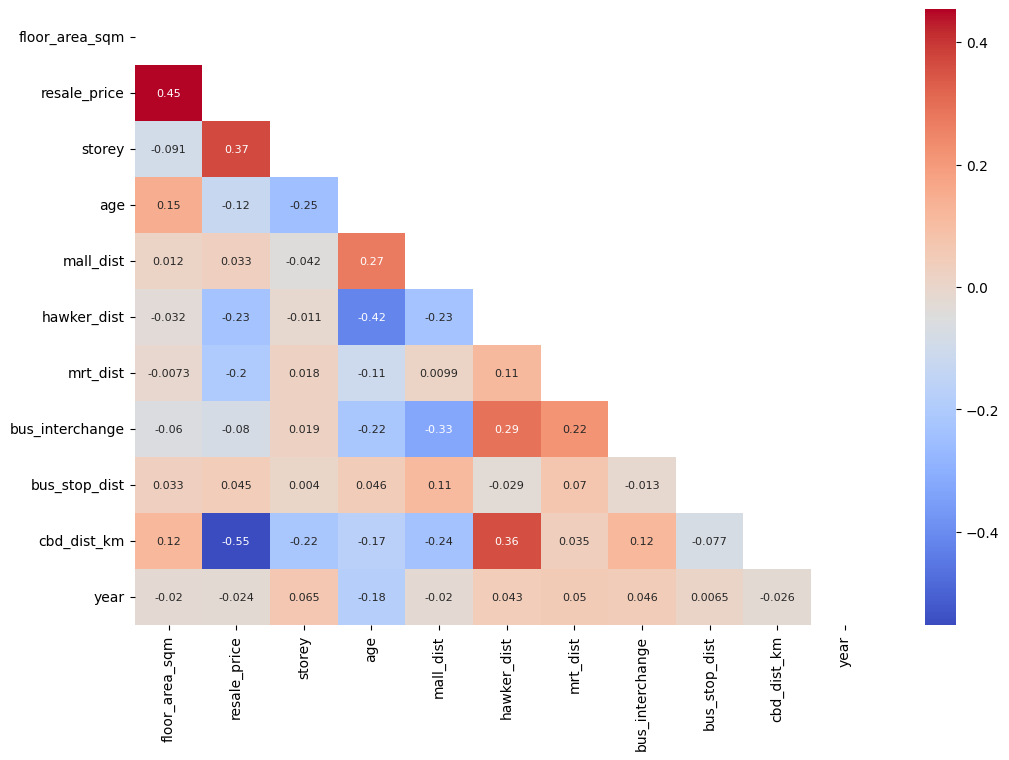

In [28]:
# Filtering out all non numerical columns
hdb_4n5_corr = hdb_4n5_eda.drop(columns=['transact_date', 'town', 'pri_sch', 'flat_type', 'pri_sch_tier'])

# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust width and height as needed

# Creating mask to hide upper triangular part
mask = np.triu(np.ones_like(hdb_4n5_corr.corr()))

# Plotting heatmap
sns.heatmap(hdb_4n5_corr.corr(), annot=True, cmap='coolwarm', annot_kws={"size":8}, mask=mask)

*Early Findings*
* Floor area remains the strongest correlations with resale value, followed by age, storey and cbd distance

##### Persona 1:

* Works near CBD, wants convenience in commute
* Minimum 4 room
* Wants to get child into tier-1 school

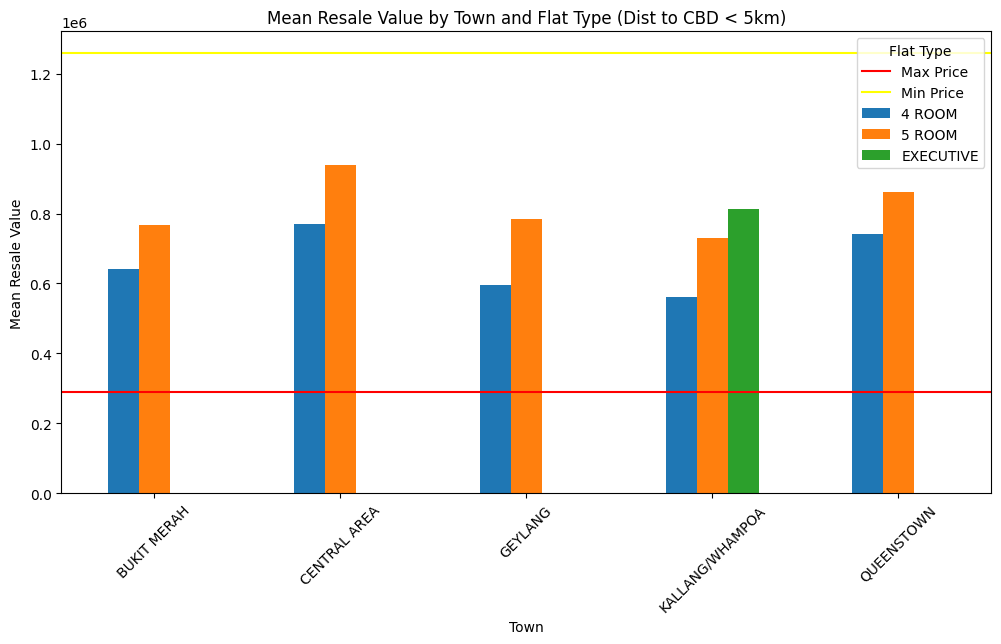

290000.0
1258000.0


In [29]:
# Filter the data by cbd_dist_km < 5km
hdb_4n5_eda_filtered = hdb_4n5_eda[hdb_4n5_eda['cbd_dist_km'] < 5]

# Group the filtered data by 'town' and 'flat_type' and calculate the mean resale value for each group
town_flat_type_resale_mean = hdb_4n5_eda_filtered.groupby(['town', 'flat_type'])['resale_price'].mean().unstack()

# Minimum price of flats that meet these criteria
min_price = hdb_4n5_eda_filtered['resale_price'].min()
max_price = hdb_4n5_eda_filtered['resale_price'].max()

# Plot the bar chart
town_flat_type_resale_mean.plot(kind='bar', figsize=(12, 6))
plt.axhline(min_price, label = 'Max Price', c = 'r')
plt.axhline(max_price, label = 'Min Price', c= 'yellow')
plt.xlabel('Town')
plt.ylabel('Mean Resale Value')
plt.title('Mean Resale Value by Town and Flat Type (Dist to CBD < 5km)')
plt.xticks(rotation=45)
plt.legend(title='Flat Type')
plt.show()

print(min_price)
print(max_price)


**Interpretation:**
* Kallang/Whampoa area offers the most affordable resale prices for units within 5KM of distance to CBD. This applies for 4 and 5 room flat types, while also offering executive flats which are generally larger and of limited supply.

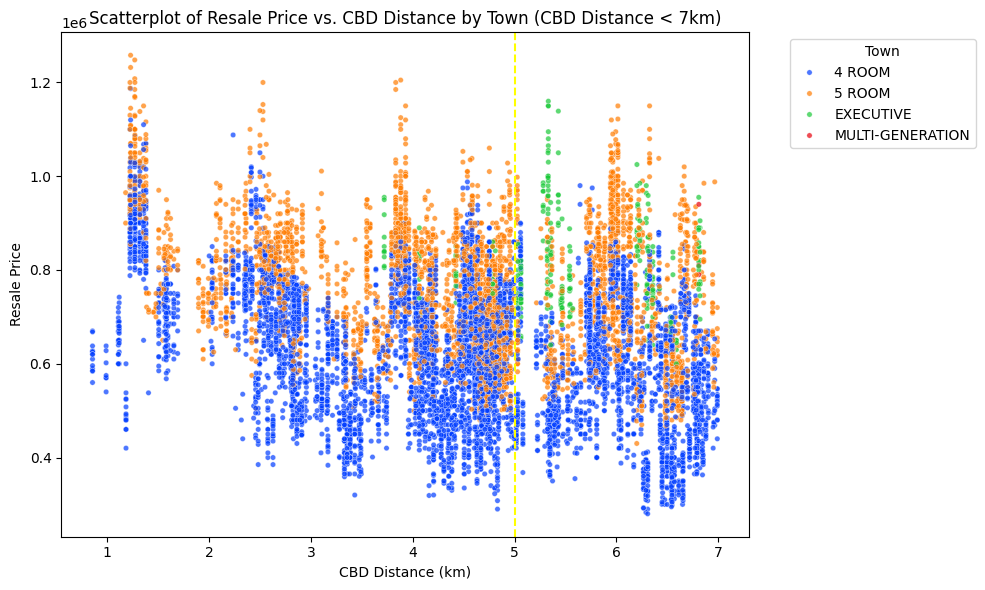

In [30]:
# Filter the DataFrame
hdb_filtered_7 = hdb_4n5_eda[hdb_4n5_eda['cbd_dist_km'] < 7]

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=hdb_filtered_7, x='cbd_dist_km', y='resale_price', hue='flat_type', palette='bright', alpha=0.7, s=15)

# Set labels and title
plt.xlabel('CBD Distance (km)')
plt.ylabel('Resale Price')
plt.title('Scatterplot of Resale Price vs. CBD Distance by Town (CBD Distance < 7km)')

# Set a vertical line for 5KM
plt.axvline(x=5, color='yellow', linestyle='--')  # Adjust the value of x as needed

# Show the plot
plt.legend(title='Town', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Interpretation:**
* Between 2.5KM to 5KM, min resale prices generally trend down and availability of units increase. This could be an area that our client can look into, offering a near enough distance to CBD without breaking the bank.

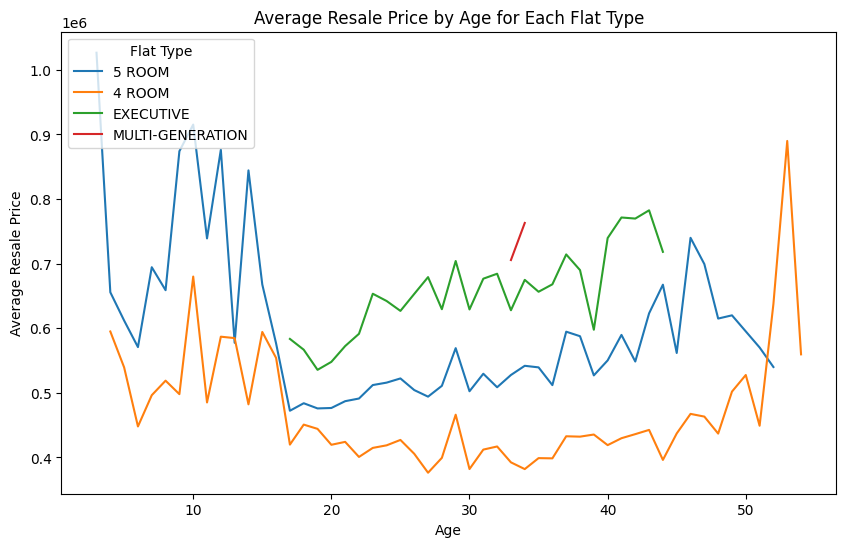

In [31]:
average_prices = hdb_4n5_eda.groupby(['age', 'flat_type'])['resale_price'].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_prices, x='age', y='resale_price', hue='flat_type')
plt.xlabel('Age')
plt.ylabel('Average Resale Price')
plt.title('Average Resale Price by Age for Each Flat Type')
plt.legend(title='Flat Type', loc='upper left')
plt.show()

**Interpretation:**
Units within 5KM radius of CBD also follows the trend of hdb age with resale price - after 20 years, the property valuation increases gradually. Thus, old units may not be too much of a problem.

C:\Users\ng_we\AppData\Local\Temp\ipykernel_21160\775375083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hdb_4n5_eda_filtered['transact_year'] = pd.to_datetime(hdb_4n5_eda_filtered['transact_date']).dt.year


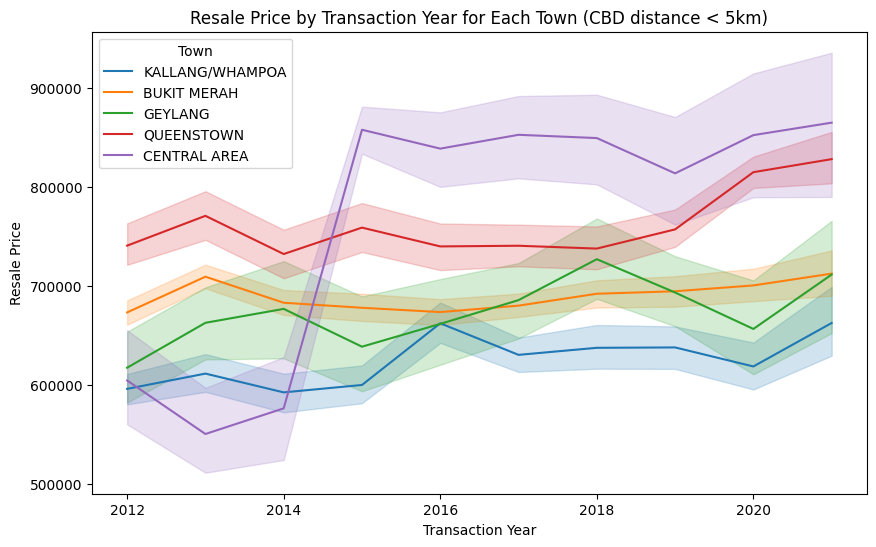

In [32]:
# Extract the year from the 'transact_date' column
hdb_4n5_eda_filtered['transact_year'] = pd.to_datetime(hdb_4n5_eda_filtered['transact_date']).dt.year

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=hdb_4n5_eda_filtered, x='transact_year', y='resale_price', hue='town')
plt.xlabel('Transaction Year')
plt.ylabel('Resale Price')
plt.title('Resale Price by Transaction Year for Each Town (CBD distance < 5km)')
plt.legend(title='Town', loc='upper left')
plt.show()

**Interpretation:**
* Central area experienced a huge spike in average resale price in 2015, from being one of the lowest prices within 5KM distance to CBD to the highest and maintaining that status over 2015 to 2021.
* Kallang/Whampoa, Bukit Merah and Geylang areas offer more affordable options that experience a gradual increase in resale price.

C:\Users\ng_we\AppData\Local\Temp\ipykernel_21160\1837230363.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['transact_year'] = pd.to_datetime(filtered_data['transact_date']).dt.year


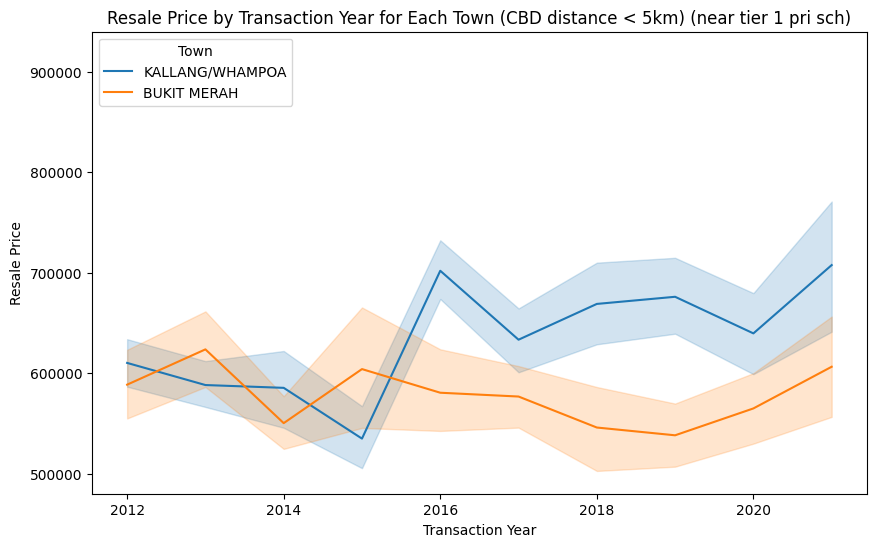

In [33]:
# Filter the DataFrame by pri_sch_tier_1 and cbd_dist_km<5
filtered_data = hdb_4n5_eda[(hdb_4n5_eda['pri_sch_tier'] == 'pri_sch_tier_1') & (hdb_4n5_eda['cbd_dist_km'] < 5)]

# Extract the year from the 'transact_date' column
filtered_data['transact_year'] = pd.to_datetime(filtered_data['transact_date']).dt.year

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_data, x='transact_year', y='resale_price', hue='town')
plt.ylim(480000, 940000)
plt.xlabel('Transaction Year')
plt.ylabel('Resale Price')
plt.title('Resale Price by Transaction Year for Each Town (CBD distance < 5km) (near tier 1 pri sch)')
plt.legend(title='Town', loc='upper left')
plt.show()

**Interpretation:**
* Applying a further filter to meet the client's requirement of being near a Tier 1 school, Kallang/Whampoa offers itself as a better option as price has increased over the last 10 years more than Bukit Merah. Only these 2 towns meet both criterias.
* A further look into Kallang/Whampoa also shows that there are more than 1 Tier 1 schools nearby, namely Hongwen Primary school and SJI Junior.

In [34]:
filtered_data[(filtered_data['town']=='KALLANG/WHAMPOA') & (filtered_data['pri_sch_tier']=='pri_sch_tier_1')][['town', 'pri_sch', 'pri_sch_tier']].head()

,town,pri_sch,pri_sch_tier
32,KALLANG/WHAMPOA,Hong Wen School,pri_sch_tier_1
493,KALLANG/WHAMPOA,Hong Wen School,pri_sch_tier_1
610,KALLANG/WHAMPOA,Hong Wen School,pri_sch_tier_1
1174,KALLANG/WHAMPOA,Hong Wen School,pri_sch_tier_1
1455,KALLANG/WHAMPOA,Hong Wen School,pri_sch_tier_1


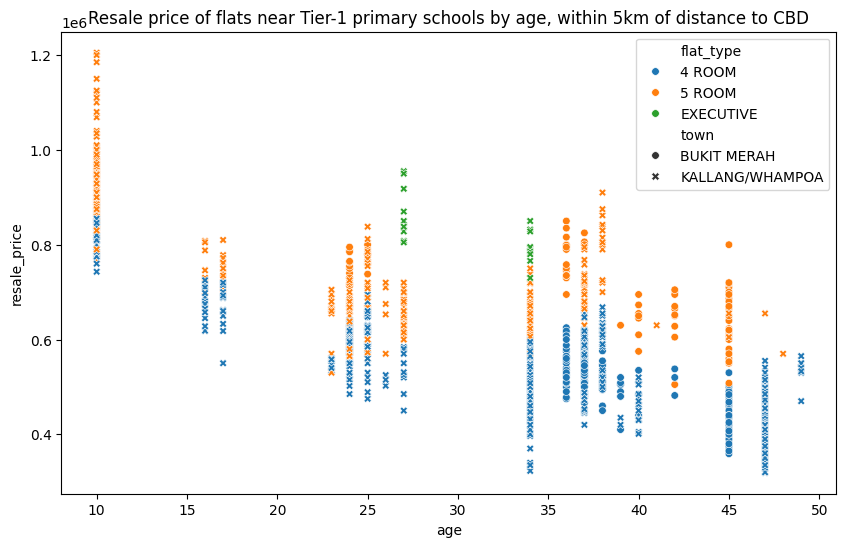

In [35]:
# Sort the DataFrame by town
filtered_data = filtered_data.sort_values(by='town')

# Plot scatterplot with different marker types for each town
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='age', y='resale_price', hue='flat_type', style='town', s=30)
plt.title('Resale price of flats near Tier-1 primary schools by age, within 5km of distance to CBD')
plt.show()

**Interpretation:**
* Kallang/Whampoa offers more 4 and 5 room flat types than bukit merah
* These units also cover both min and max resale values of their corresponding HDB ages.